# ***MoveInSync Assignment***

Design a **time series forecasting model** to predict values for the next **three months** based on the provided historical data
**Output should be filled csv file(test1.csv).**
Date range for testing - 01-10-2017 to 31-12-2017


In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from google.colab import drive
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Mount Google Drive
# drive.mount('/content/drive')
# Load data
train_path = "/content/train1.csv"
test_path = "/content/test1.csv"
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

# Pre-process Data

In [ ]:
# Convert date column to datetime  (initially it is in object data type convert into datetime)
df_train['date'] = pd.to_datetime(df_train['date'], dayfirst=True)
df_test['date'] = pd.to_datetime(df_test['date'], dayfirst=True)
print("Training Data Initial Info:")
print(df_train.info())
print("\nTesting Data Initial Info:")
print(df_test.info())

Training Data Initial Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1369 entries, 0 to 1368
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1369 non-null   datetime64[ns]
 1   price   1369 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 21.5 KB
None

Testing Data Initial Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    92 non-null     datetime64[ns]
 1   price   0 non-null      float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.6 KB
None


In [ ]:
# Set date as index
df_train.set_index('date', inplace=True)
df_test.set_index('date', inplace=True)

In [ ]:
# Feature Engineering
def create_time_features(df):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.weekday
    df['day_of_year'] = df.index.dayofyear
    df['quarter'] = df.index.quarter
    return df

df_train = create_time_features(df_train)
df_test = create_time_features(df_test)
print(df_train,df_test)
print(df_train.info(),df_test.info())

            price  year  month  day  day_of_week  day_of_year  quarter
date                                                                  
2014-01-01      9  2014      1    1            2            1        1
2014-01-02     14  2014      1    2            3            2        1
2014-01-03     11  2014      1    3            4            3        1
2014-01-04     20  2014      1    4            5            4        1
2014-01-05     17  2014      1    5            6            5        1
...           ...   ...    ...  ...          ...          ...      ...
2017-09-26     18  2017      9   26            1          269        3
2017-09-27     27  2017      9   27            2          270        3
2017-09-28     23  2017      9   28            3          271        3
2017-09-29     28  2017      9   29            4          272        3
2017-09-30     30  2017      9   30            5          273        3

[1369 rows x 7 columns]             price  year  month  day  day_of_week  da

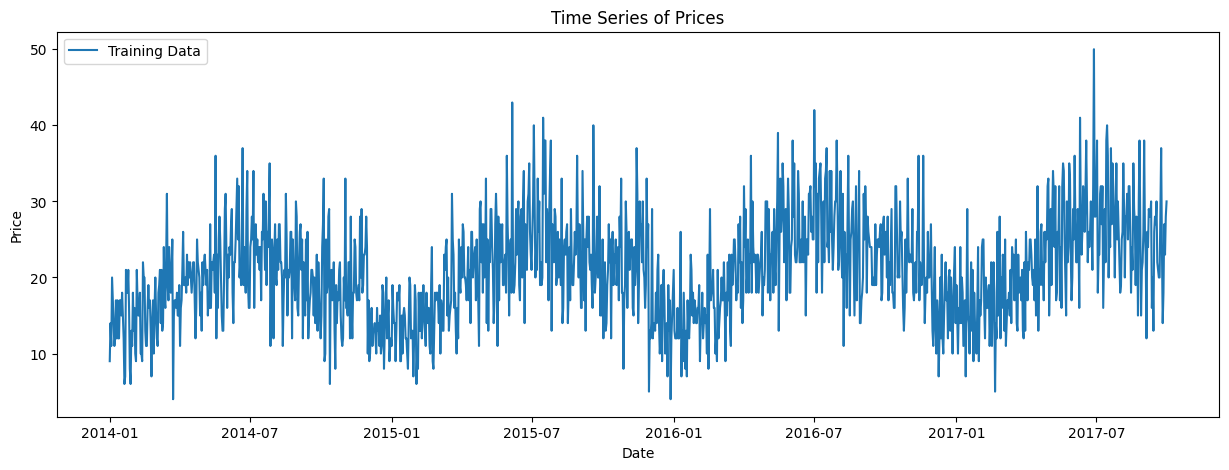

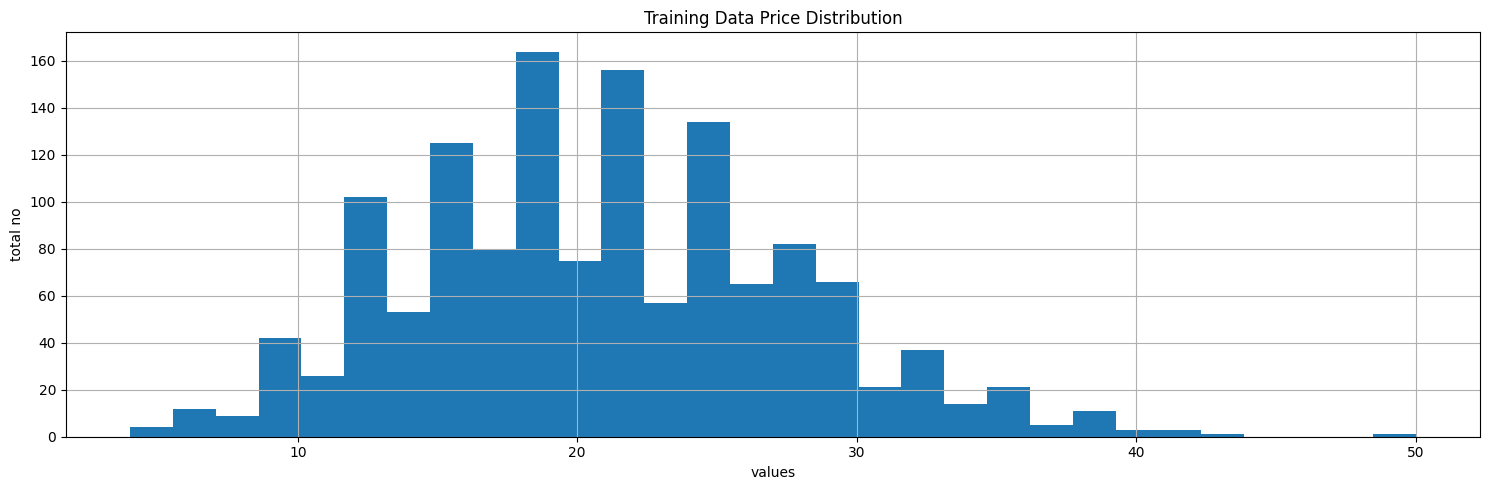

In [ ]:
# visualize data distribution

# Time series plot
plt.figure(figsize=(15, 5))
plt.plot(df_train.index, df_train['price'], label='Training Data')
plt.title('Time Series of Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Distribution plot
plt.figure(figsize=(15, 5))
df_train['price'].hist(bins=30)
plt.xlabel('values')
plt.ylabel('total no')
plt.title('Training Data Price Distribution')
plt.tight_layout()
plt.show()

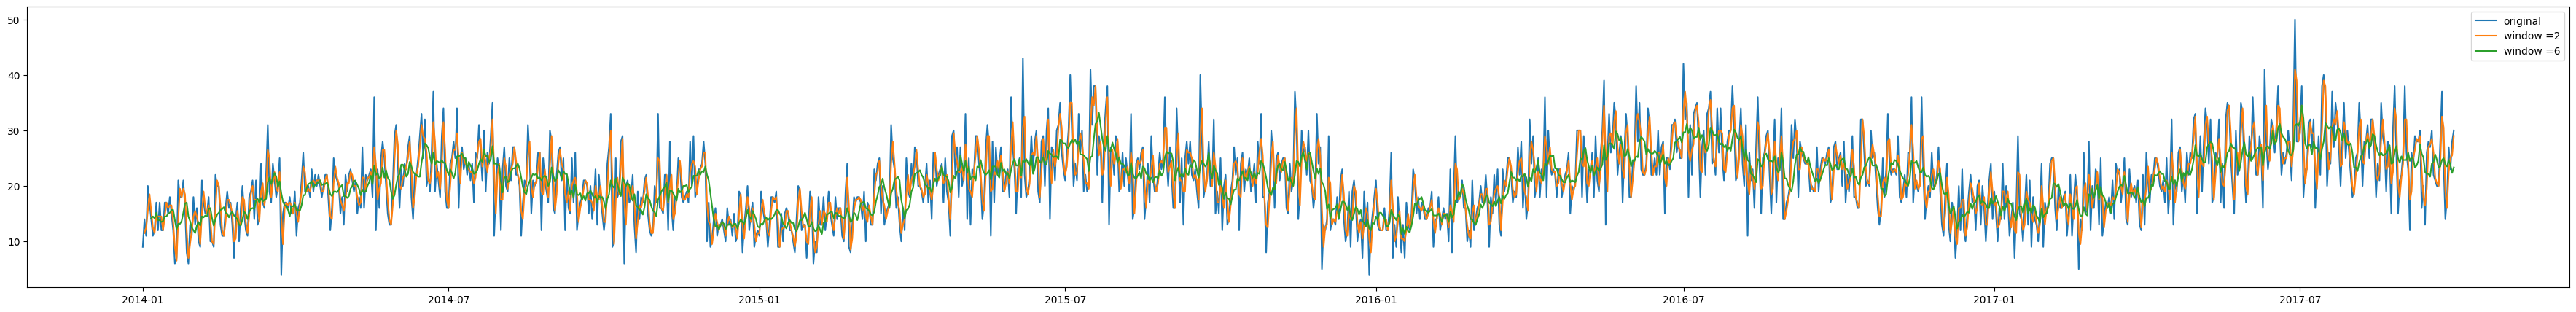

In [ ]:
df_train['rolling_mean'] = df_train.price.rolling( window=2).mean()
df_train['rolling_mean6'] = df_train.price.rolling( window=6).mean()
plt.figure(figsize=(45, 5))
plt.plot(df_train.price, label='original')
plt.plot(df_train.rolling_mean, label = 'window =2')
plt.plot(df_train.rolling_mean6, label = 'window =6')
plt.legend(loc='best')

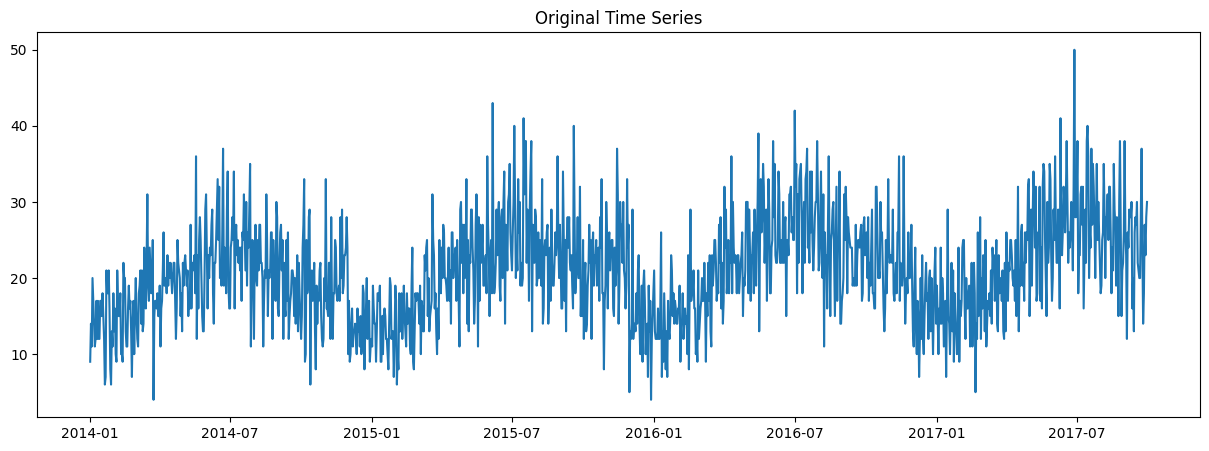

Original Data ADF Test Results:
ADF Statistic: -2.388694741350324
p-value: 0.1449526909824866
Critical Values: {'1%': -3.4352139981780865, '5%': -2.863688081179776, '10%': -2.567913641703717}


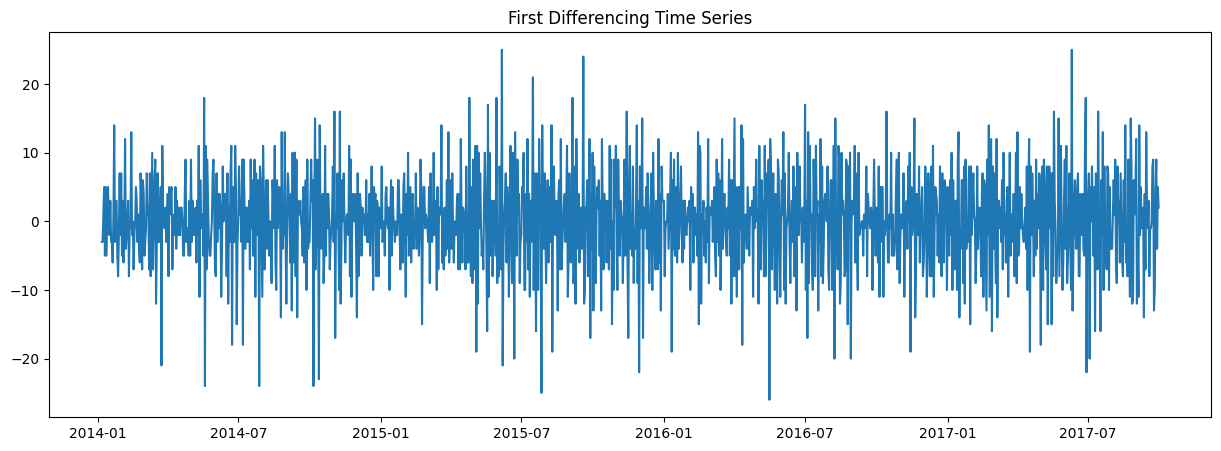


First Differenced Data ADF Test Results:
ADF Statistic: -13.227956624020345
p-value: 9.714948879013185e-25
Critical Values: {'1%': -3.43522851297339, '5%': -2.8636944861078013, '10%': -2.5679170525584523}
The data is now stationary after differencing.


<ipython-input-62-90d3aa4e1a7b>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[f'{column}_diff']


In [ ]:
def check_and_transform_stationarity(df, column, seasonal_period=12):
    # Plot the original series
    plt.figure(figsize=(15, 5))
    plt.plot(df[column])
    plt.title('Original Time Series')
    plt.show()

    # Perform Dickey-Fuller test on the original series
    adf_test = adfuller(df[column])
    print('Original Data ADF Test Results:')
    print('ADF Statistic:', adf_test[0])
    print('p-value:', adf_test[1])
    print('Critical Values:', adf_test[4])

    # if condition true then Non-stationary
    if adf_test[1] >= 0.05:
        # First differencing
        df[f'{column}_diff'] = df[column].diff()
        df = df.dropna()
        plt.figure(figsize=(15, 5))
        plt.plot(df[f'{column}_diff'])
        plt.title('First Differencing Time Series')
        plt.show()

        # Perform Dickey-Fuller test on differenced series
        diff_adf_test = adfuller(df[f'{column}_diff'])
        print('\nFirst Differenced Data ADF Test Results:')
        print('ADF Statistic:', diff_adf_test[0])
        print('p-value:', diff_adf_test[1])
        print('Critical Values:', diff_adf_test[4])

        if diff_adf_test[1] < 0.05:
            print("The data is now stationary after differencing.")
            df[column] = df[f'{column}_diff']
            df = df.drop(columns=[f'{column}_diff'])
            return df
        else:
            print("The data is still non-stationary after differencing. Applying seasonal differencing.")

            # Seasonal differencing
            df[f'{column}_seasonal_diff'] = df[column] - df[column].shift(seasonal_period)
            df = df.dropna()
            plt.figure(figsize=(15, 5))
            plt.plot(df[f'{column}_seasonal_diff'])
            plt.title('Seasonal Differencing Time Series')
            plt.show()

            # Perform Dickey-Fuller test on seasonally differenced series
            seasonal_diff_adf_test = adfuller(df[f'{column}_seasonal_diff'])
            print('\nSeasonally Differenced Data ADF Test Results:')
            print('ADF Statistic:', seasonal_diff_adf_test[0])
            print('p-value:', seasonal_diff_adf_test[1])
            print('Critical Values:', seasonal_diff_adf_test[4])

            if seasonal_diff_adf_test[1] < 0.05:
                print("The data is now stationary after seasonal differencing.")
                df[column] = df[f'{column}_seasonal_diff']
                df = df.drop(columns=[f'{column}_seasonal_diff'])
                return df
            else:
                print("The data is still non-stationary even after seasonal differencing.")
    else:
        print("The data is already stationary.")
    return df

df_train = check_and_transform_stationarity(df_train, 'price')

# **Train / Test Split**

Train data:
             price  year  month  day  day_of_week  day_of_year  quarter  \
date                                                                     
2016-08-27   -1.0  2016      8   27            5          240        3   
2016-08-28   10.0  2016      8   28            6          241        3   
2016-08-29  -20.0  2016      8   29            0          242        3   
2016-08-30    0.0  2016      8   30            1          243        3   
2016-08-31    3.0  2016      8   31            2          244        3   

            rolling_mean  rolling_mean6  
date                                     
2016-08-27          24.5      22.833333  
2016-08-28          29.0      26.000000  
2016-08-29          24.0      24.333333  
2016-08-30          14.0      21.333333  
2016-08-31          15.5      21.333333  
Test data:
             price  year  month  day  day_of_week  day_of_year  quarter  \
date                                                                     
2016-08-31    

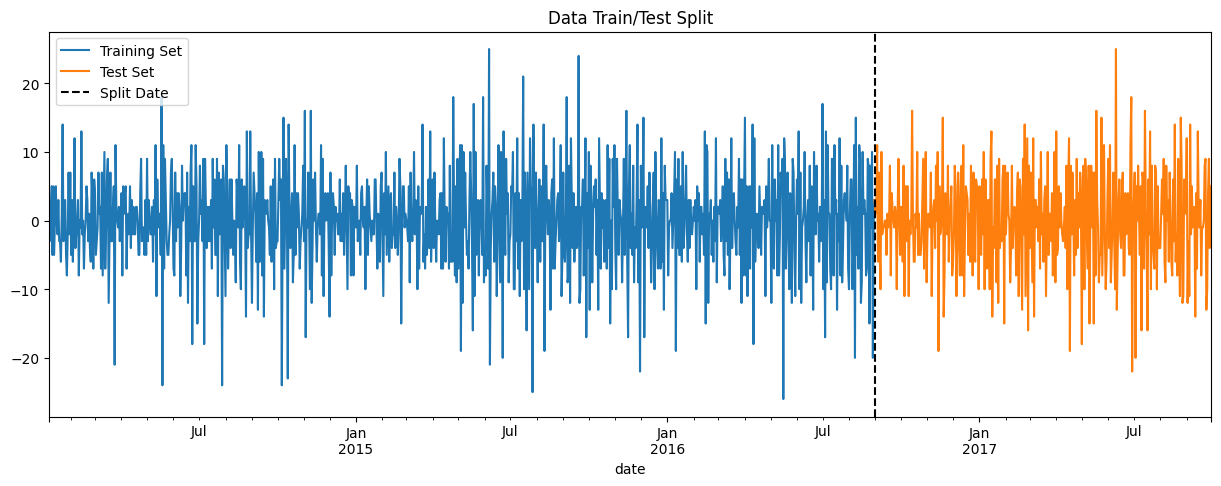

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
split_date = '2016-08-31'
train = df_train[:split_date]
test = df_train[split_date:]

print("Train data:\n", train.tail())
print("Test data:\n", test.head())

# Plotting the split
fig, ax = plt.subplots(figsize=(15, 5))
train['price'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['price'].plot(ax=ax, label='Test Set')
ax.axvline(pd.to_datetime(split_date), color='black', linestyle='--', label='Split Date')
ax.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

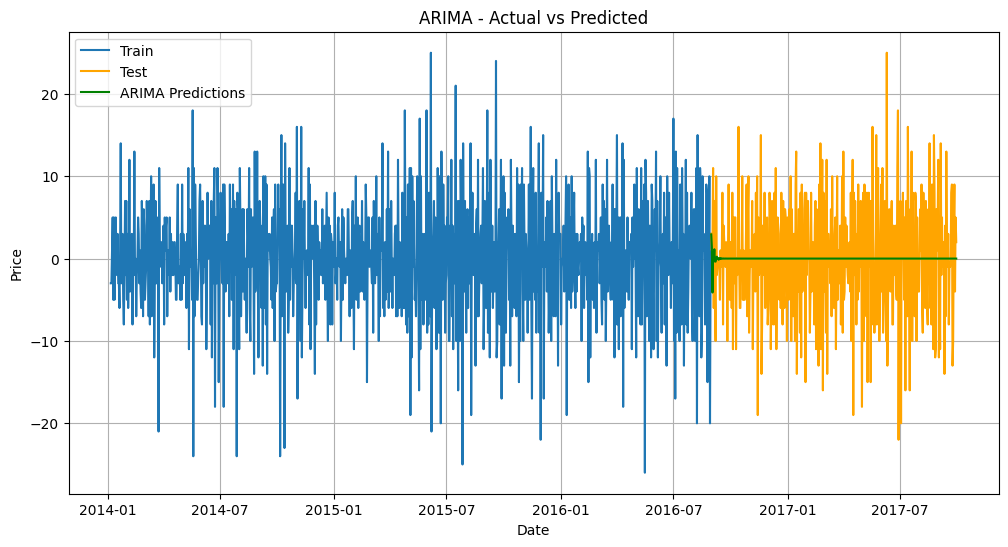

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


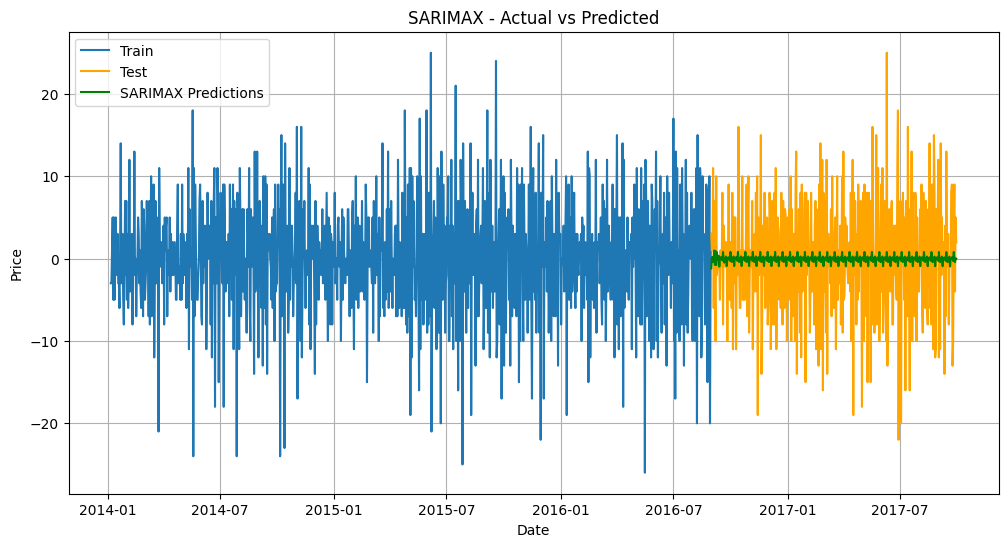

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


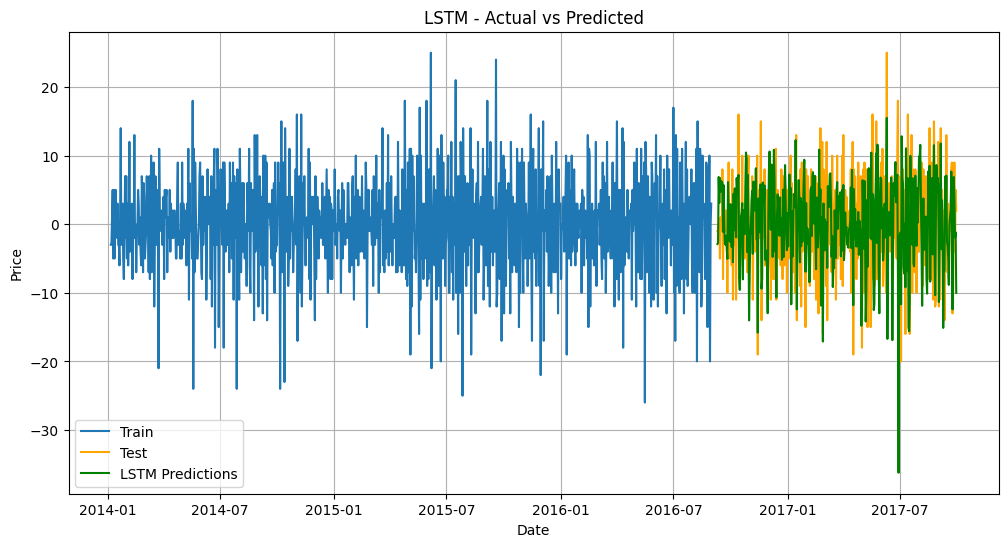

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


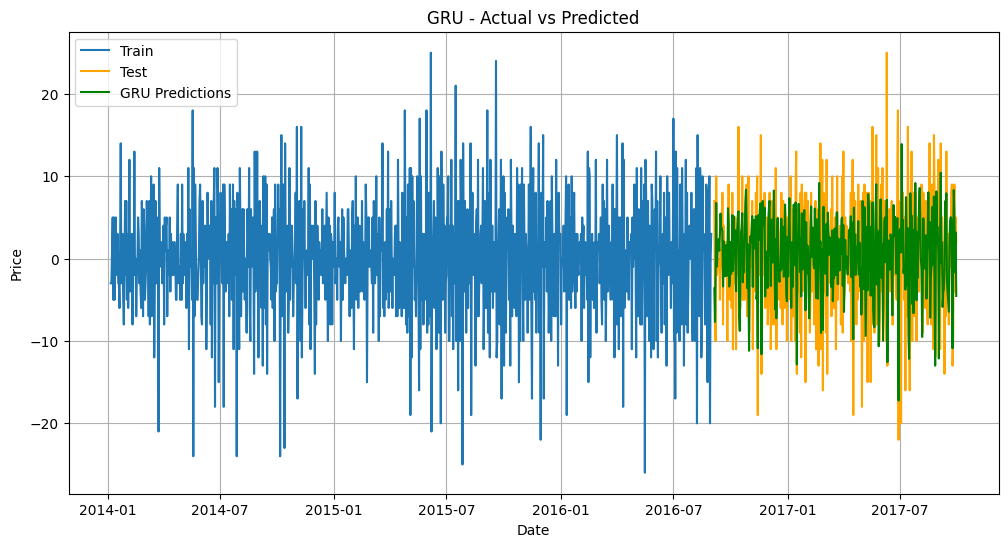

Best Parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.7}


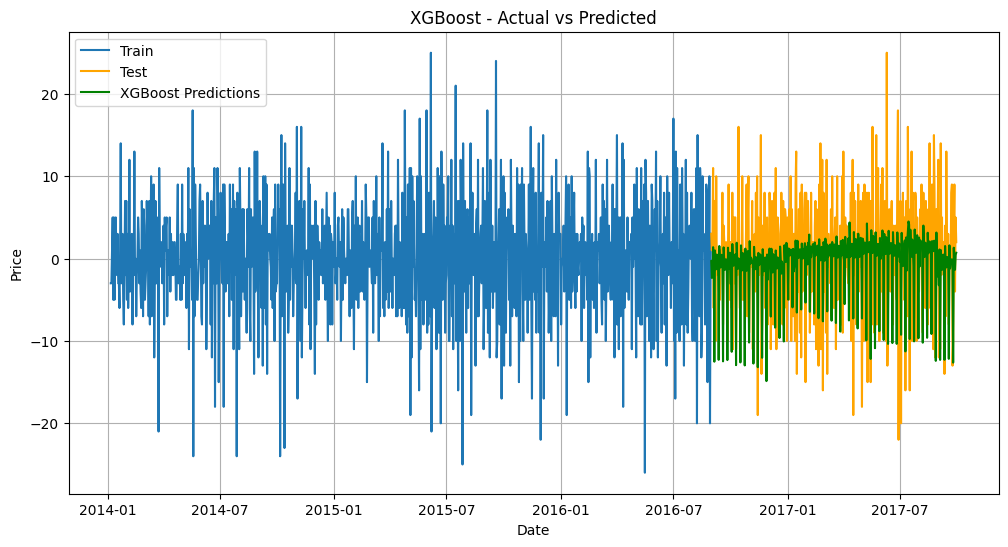

Model Evaluation Metrics:
ARIMA: {'MSE': 54.46813326374315, 'RMSE': 7.380252926813765, 'MAE': 5.935967905478987}
SARIMAX: {'MSE': 54.58501481041401, 'RMSE': 7.388167215921281, 'MAE': 5.956220963255269}
LSTM: {'MSE': 36.826567175802516, 'RMSE': 6.068489694792479, 'MAE': 4.878295377538651}
GRU: {'MSE': 36.201402302340846, 'RMSE': 6.016760116735655, 'MAE': 4.796634562604148}
XGBoost: {'MSE': 45.7754409069244, 'RMSE': 6.765755013812162, 'MAE': 5.432223346027913}


In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import math
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout


import xgboost as xgb


# Evaluation metrics
def evaluate_model(true, predicted):
    mse = mean_squared_error(true, predicted)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(true, predicted)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae}


# Plot actual vs predicted
def plot_results(train, test, predictions, model_name):
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['price'], label='Train')
    plt.plot(test.index, test['price'], label='Test', color='orange')
    plt.plot(test.index, predictions, label=f'{model_name} Predictions', color='green')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()


# Helper: Prepare sequence data for LSTM and GRU
def prepare_sequence_data(data, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)


# Helper: Scale and reshape data for neural networks
def preprocess_nn_data(train, test, look_back):
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    X_train, y_train = prepare_sequence_data(train_scaled, look_back)
    X_test, y_test = prepare_sequence_data(test_scaled, look_back)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    return X_train, y_train, X_test, y_test, scaler


# ARIMA Model
def run_arima(train, test, order=(5, 1, 2)):
    model = ARIMA(train['price'], order=order)
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test))
    metrics = evaluate_model(test['price'], predictions)
    plot_results(train, test, predictions, 'ARIMA')
    return metrics


# SARIMAX Model
def run_sarimax(train, test, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)):
    model = SARIMAX(train['price'], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    predictions = model_fit.forecast(steps=len(test))
    metrics = evaluate_model(test['price'], predictions)
    plot_results(train, test, predictions, 'SARIMAX')
    return metrics


# LSTM Model
def run_lstm(train, test, look_back=10, epochs=100, batch_size=16):
    train_values = train['price'].values.reshape(-1, 1)
    test_values = test['price'].values.reshape(-1, 1)
    X_train, y_train, X_test, y_test, scaler = preprocess_nn_data(train_values, test_values, look_back)
    # model = Sequential([
    #     LSTM(50, activation='relu', input_shape=(look_back, 1)),
    #     Dense(1)
    # ])
    # model.compile(optimizer='adam', loss='mse')

    model = Sequential([
          LSTM(100, activation='relu', return_sequences=True, input_shape=(look_back, 1)),
          Dropout(0.2),
          LSTM(50, activation='relu'),
          Dense(1)
      ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.Huber())
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    predictions = scaler.inverse_transform(model.predict(X_test))
    metrics = evaluate_model(test['price'].iloc[look_back:], predictions)
    plot_results(train, test[look_back:], predictions, 'LSTM')
    return metrics,model,scaler


# GRU Model
def run_gru(train, test, look_back=5, epochs=50, batch_size=32):
    train_values = train['price'].values.reshape(-1, 1)
    test_values = test['price'].values.reshape(-1, 1)
    X_train, y_train, X_test, y_test, scaler = preprocess_nn_data(train_values, test_values, look_back)
    model = Sequential([
        GRU(50, activation='relu', input_shape=(look_back, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    predictions = scaler.inverse_transform(model.predict(X_test))
    metrics = evaluate_model(test['price'].iloc[look_back:], predictions)
    plot_results(train, test[look_back:], predictions, 'GRU')
    return metrics

# XGBoost Model with optional Grid Search
def run_xgboost(train, test, features, target, params=None, use_grid_search=True):
    if params is None:
        params = {
            'learning_rate': [0.1],
            'max_depth': [3],
            'n_estimators': [50],
            'reg_alpha': [0],
            'reg_lambda': [0],
            'subsample': [0.7],
            'colsample_bytree': [0.7]
        }

    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]

    if use_grid_search:
        model = xgb.XGBRegressor(objective='reg:squarederror')
        grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_
        print("Best Parameters:", grid_search.best_params_)
    else:
        best_model = xgb.XGBRegressor(objective='reg:squarederror', **params)
        best_model.fit(X_train, y_train)

    predictions = best_model.predict(X_test)
    metrics = evaluate_model(y_test, predictions)
    plot_results(train, test, predictions, 'XGBoost')

    return metrics


arima_metrics = run_arima(train, test)
sarimax_metrics = run_sarimax(train, test)
lstm_metrics, lstmmodel, scaler = run_lstm(train, test)
gru_metrics = run_gru(train, test)
xgboost_metrics = run_xgboost(train, test, features=['year', 'month', 'day', 'day_of_week', 'day_of_year', 'quarter'], target='price', params=None, use_grid_search=True)


# xgboost_metrics = run_xgboost(train, test, features=['year', 'month', 'day', 'day_of_week', 'day_of_year', 'quarter'], target='price')


# Display evaluation results
print("Model Evaluation Metrics:")
print("ARIMA:", arima_metrics)
print("SARIMAX:", sarimax_metrics)
print("LSTM:", lstm_metrics)
print("GRU:", gru_metrics)
print("XGBoost:", xgboost_metrics)


In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

look_back = 10
# df_test.reset_index(inplace=True)
def prepare_test_data(test_data, look_back, scaler):
    test_values = test_data['price'].values.reshape(-1, 1)
    test_scaled = scaler.transform(test_values)
    X_test = []
    for i in range(len(test_scaled) - look_back):
        X_test.append(test_scaled[i:i+look_back])

    X_test = np.array(X_test)
    return X_test

X_test = prepare_test_data(df_test, look_back, scaler)
predictions = lstmmodel.predict(X_test)
# print(predictions)
predicted_prices = scaler.inverse_transform(predictions)
result_df = pd.DataFrame({
    'date': df_test['date'].values[look_back:],
    'predicted_price': predicted_prices.flatten()
})

plt.figure(figsize=(10, 6))
plt.plot(result_df['date'], result_df['predicted_price'], label='Predicted Price', color='blue')
plt.title('Predicted Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


ValueError: cannot insert level_0, already exists

In [ ]:
result_df.to_csv('/content/test1.csv', index=False)

In [70]:
result_df.head()

,date,predicted_price
0,2017-10-11,NaN
1,2017-10-12,NaN
2,2017-10-13,NaN
3,2017-10-14,NaN
4,2017-10-15,NaN
